# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [4]:


import json
import requests
import random
import string
import secrets
import time
import re
import collections
import pandas as pd
import numpy as np
#import tensorflow as tf
#from keras.models import Model, load_model
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import string
import random
import math

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Strategy

The problem requires to make a strategy through which we can suggest a letter to predict the hangman word.
Since the n-gram word prediction was discouraged. Another approach that became obvious was to use Reinforcement learning

Since it is mentioned that the word dictionary will be disjoint set from provided set, RL approach will be able to learn letter level frequency and expected probability distributions on these hangman words.

I chose **DQN RL** agent approach since the dictionary in the submission simulation will going to be entirelydifferent. 
An off policy algorithm seemed to be more suited for the problem.

In this approach the agent goes through exploration initially and later with accumulated experiences start to exploit, the shift is managed with epsilon.

## Peek to major components of DQN agent:

### Policy Network and Target Network structure

To train Policy Net and Target net, the deep neural network i chose had 26 input variables and 26 output variables.

* *Input nodes* : The input nodes of neural network took the frequency count of each letter from 26 alphabets basis the given text to the agent.
                    For example, '___' will give a tensor of 26 zeros
* *Output node* : The output nodes gives the probability of each letter which is the action of the agent.

The number of hidden layers and number of nodes in those layers are basis hit and trials and also considering performance capability of my machine

### Reward Structure

For reward i tried 2-3 structures but settled for the following:
- For each correct guess 1 reward point was awarded. In case a letter is repeated the reward will also be repeated
- For winning a game additional 10reward points were given
- For losing a game the agent will get -1 reward
- For failed attempt until the trials does not reach 0, there was no reward


## Challenge faced

The major challenge i faced was during training. Post initial debugging and reaching to a working model i noticed i could not utilized the large sample space due to computation limitation

To speed up I chose to use pytorch tensor based algorithm since it has capability to use GPUs.
I saw some improvement but still not able to use a large sample space.

Then i ran it for 2500 sample space and after the wait i found that the performance is not much.

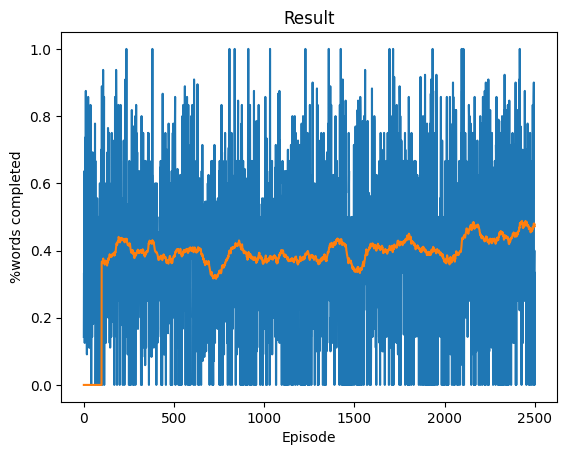

I noticed on an average it is able to complete 44% of letters. The success rate of completing full hangman word was 0.98%. 
This is very low i understand.
I tried changing architecture of neural network, learning rate and gamma and tau factors as well but did not seem to make any difference.

I had to submit my solution since I was short of time.
Thinking more on it I figured there is more information available to me when playing the game and that can also be provided to the agent.
The following ideas are what I am going to implemement:
* Changing the input node from tensor of 26 length to 53 length decribing as follows:

         1. First node will input the length of given text.
         2. Next 26 nodes will take the frequency of each alphabet in the word which is given to the agent. As we have initially used
         3. The next 26 nodes will give flags for the words which have already been predicted by the agent.

In [5]:
wordlist = pd.read_table('words_250000_train.txt',header=None)
word_list = wordlist[0].to_list()

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x=F.softmax(self.layer3(x),dim=1)
        return x

In [7]:
def word_to_state(word):
  state = np.zeros(26)
  for i in range(len(word)):
      if word[i] in ('_'," "):
          continue
      state[ord(word[i])-97] += 1
  return state

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.95
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 500
TAU = 0.04
LR = 0.05

# Get number of actions from gym action space
n_actions = 26
# Get the number of state observations
state=[0]*26
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
 #           x= policy_net(state).max(1)[1].view(1, 1)
            return policy_net(state)
            #print("nn output action",policy_net(state))
#            return x
    else:
       # print('random')
        return torch.tensor(word_to_state(random.choice(list(string.ascii_lowercase))).reshape(1,-1), device=device, dtype=torch.long)
        #print('random =====>',x.size())
#        return x


score = []


def plot_rewards(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('%words completed')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values=policy_net(state_batch).gather(1,torch.argmax(action_batch,dim=1).unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


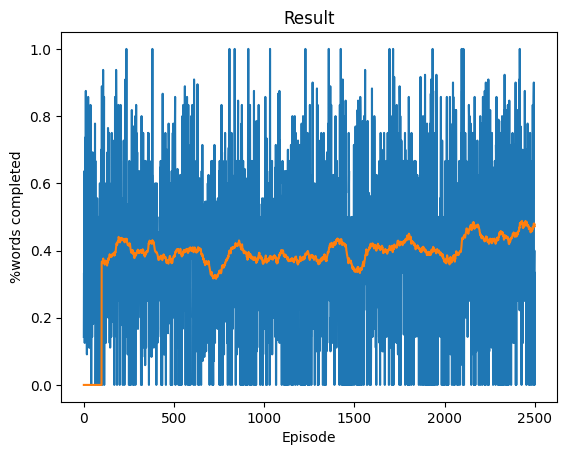

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
if torch.cuda.is_available():
    num_episodes = 4500
else:
    num_episodes = 2500

a=random.sample(range(0,len(word_list)),num_episodes)
wordlist1=[word_list[i] for i in a]

def reward_value(word):
    return sum(1 for char in word if char.isalpha())


def env(tgt,curr,action,trials):
  act_letter = chr(torch.argmax(action).item()+97)
  #print(torch.argmax(action),"====",torch.argmax(action).item(),"   ",act_letter)
  prev_rew=reward_value(curr)
  if act_letter in tgt:
    for i in range(len(tgt)):
      if tgt[i] == act_letter:
        curr= curr[:i]+act_letter+curr[i+1:]
  else:
    trials-=1
  return curr,((reward_value(curr)-prev_rew)+((curr==tgt)*10))*(trials>0)+(trials<=0)*-1,curr==tgt,trials<=0,trials
#num_episodes = 3
#wordlist1=['aaa','stand','apple']
for i_episode in range(num_episodes):
    trial_left = 6
    tgt_wrd = wordlist1[i_episode]
    # Initialize the environment and get it's state
    curr = '_'*len(tgt_wrd)
    guessed_letters=[]
    state = torch.tensor([0]*26, dtype=torch.float32, device=device).unsqueeze(0)
    while(1):
  #      state = torch.tensor(word_to_state(curr), dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state)
        #print("select action====>",action)
        guess_lett = chr(torch.argmax(action).item()+97)
        if guess_lett not in guessed_letters:
            guessed_letters.append(guess_lett)
        else: 
            continue
        #print(" tgt_wrd ===",tgt_wrd,"  curr===",curr,"  action",action,"  trial_left",trial_left)
        observation, reward, terminated, truncated,trial_left = env(tgt_wrd,curr,action,trial_left)
        #print(" observation ===",observation,"  reward===",reward,"  terminated",terminated,"  truncated",truncated,"  trial_left",trial_left)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        #print("i_episode",i_episode,"action:",chr(torch.argmax(action).item()+97),"reward",reward,"done", done, terminated,truncated, " trials", trial_left)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(word_to_state(observation), dtype=torch.float32, device=device).unsqueeze(0)
        #print("state=====>",state)
        #print("next state=====>",next_state)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        curr = observation
        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            #print(i_episode,"  tgt",tgt_wrd, "   ",observation,"   ", reward)
            score.append(reward_value(observation)/len(observation))
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [76]:
torch.tensor(word_to_state("______").reshape(1,26),dtype=torch.float32)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [75]:
torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]).dtype

torch.float32

In [61]:
policy_net(torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]))

tensor([[6.8381e-11, 1.6180e-08, 3.0961e-07, 4.7137e-08, 9.9954e-01, 1.4107e-08,
         2.6565e-08, 1.4981e-09, 4.9525e-05, 4.0244e-10, 1.4844e-07, 1.4985e-05,
         1.1246e-08, 1.7181e-05, 1.6531e-08, 1.6352e-07, 5.1995e-06, 4.5427e-10,
         6.6625e-06, 3.6933e-04, 9.8139e-11, 5.9841e-10, 7.8041e-09, 5.1075e-10,
         9.1359e-07, 1.7491e-07]], grad_fn=<SoftmaxBackward0>)

In [77]:
guess_letter= policy_net(torch.tensor(word_to_state("______").reshape(1,26),dtype=torch.float32))

In [10]:
class HangmanAPI(object):
    def __init__(self,policy_net, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        self.full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(self.full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []



        
        self.state_value = [[0]*26]
        self.action_prob = [1/26]*26
        self.input_var = 26
        self.output_var = 26
        #self.policy_net = self.nn_model(self.input_var,self.output_var)
        self.policy_net=policy_net
        #self.target_net = self.nn_model(self.input_var,self.output_var)
        
        
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def word_to_state(self,word):
        state = np.zeros(26)
        for i in range(len(word)):
            if word[i] in ('_'," "):
                continue
            state[ord(word[i])-97] += 1
        return state


        
    def guess(self, word):
        guess_let= chr(97+torch.argmax(policy_net(torch.tensor(self.word_to_state(word).reshape(1,26),dtype=torch.float32))).item())
        #print(self.guessed_letters)
        #print(guess_let)
        #print(self.guessed_letters)
        if guess_let in self.guessed_letters:
            #print("random")
            return random.choice(list(set(string.ascii_lowercase)-set(self.guessed_letters)))
        return guess_let
            

    def guess1(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        # find length of passed word
        len_word = len(clean_word)
        
        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []
        
        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue
                
            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)
        
        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary
        
        
        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)
        
        c = collections.Counter(full_dict_string)
        sorted_letter_count = c.most_common()                   
        
        guess_letter = '!'
        
        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                break
            
        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    guess_letter = letter
                    break            
        
        return guess_letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

In [3]:
pip install requests

  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for charset-normalizer<4,>=2 from https://files.pythonhosted.org/packages/91/e6/8fa919fc84a106e9b04109de62bdf8526899e2754a64da66e1cd50ac1faa/charset_normalizer-3.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.4 MB/s eta 0:00:00
  Obtaining dependency information for urllib3<3,>=1.21.1 from https://files.pythonhosted.org/packages/9b/81/62fd61001fa4b9d0df6e31d47ff49cfa9de4af03adecf339c7bc30656b37/urllib3-2.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for certifi>=2017.4.17 from https://files.pythonhosted.org/packages/4c/dd/2234eab22353ffc7d94e8d13177aaa050113286e93e7b40eae01fbf7c3d9/certifi-2023.7.22-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/6

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [11]:
api = HangmanAPI(policy_net,access_token="d59e0b1b552fd8b20ed9afc31a149d", timeout=2000)


In [55]:
api.full_dictionary

['aaa',
 'aaaaaa',
 'aaas',
 'aachen',
 'aaee',
 'aag',
 'aahed',
 'aahs',
 'aal',
 'aalesund',
 'aaliis',
 'aalst',
 'aam',
 'aandahl',
 'aao',
 'aapss',
 'aar',
 'aarau',
 'aardvark',
 'aardwolf',
 'aaren',
 'aargh',
 'aarika',
 'aaronic',
 'aaronite',
 'aaronsburg',
 'aarp',
 'aarrghh',
 'aas',
 'aasvogels',
 'aaup',
 'aavso',
 'aba',
 'ababdeh',
 'abac',
 'abacas',
 'abacaxi',
 'abaci',
 'abacination',
 'abaciscus',
 'aback',
 'abaco',
 'abacterial',
 'abactinally',
 'abactor',
 'abaculus',
 'abacuses',
 'abada',
 'abaddon',
 'abadengo',
 'abadite',
 'abaft',
 'abagail',
 'abailard',
 'abaised',
 'abaisse',
 'abaka',
 'abakas',
 'abalation',
 'abalienated',
 'abalienation',
 'abalones',
 'abamp',
 'abamperes',
 'abana',
 'abandon',
 'abandoned',
 'abandonee',
 'abandoners',
 'abandonment',
 'abandons',
 'abanet',
 'abanic',
 'abantes',
 'abaptiston',
 'abarambo',
 'abaris',
 'abarticular',
 'abas',
 'abased',
 'abasedness',
 'abasements',
 'abasers',
 'abasgi',
 'abashed',
 'abashe

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [24]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


Successfully start a new game! Game ID: eb2a3ee4b910. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: r
Sever response: {'game_id': 'eb2a3ee4b910', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: m
Sever response: {'game_id': 'eb2a3ee4b910', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: d
Sever response: {'game_id': 'eb2a3ee4b910', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: h
Sever response: {'game_id': 'eb2a3ee4b910', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: f
Sever response: {'game_id': 'eb2a3ee4b910', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: b
Sever response: {'game_id': 'eb2a3ee4b910', 'status': 'failed', 'tries_remains': 0, 'word': '_ _ _ _ _ _ _ _ _ '}
Failed game: eb2a3ee4b910. Because of: # of tries exceeded!
run 40 practice games out of an 

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [25]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [12]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.009
